In [1]:
import numpy as np
import pandas as pd
import os
import saiph
#poetry add saiph 
#pyproject.toml avatar-python
#make install 
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix

url = os.environ.get("AVATAR_BASE_URL")
username = os.environ.get("AVATAR_USERNAME")
password = os.environ.get("AVATAR_PASSWORD")

from avatars.client import ApiClient
from avatars.models import AvatarizationJobCreate, AvatarizationParameters, PrivacyMetricsMultiTableJobCreate, AvatarizationMultiTableJobCreate
from avatars.models import ReportCreate
from avatars.models import TableReference, TableLink, PrivacyMetricsParameters, PrivacyMetricsMultiTableParameters, AvatarizationMultiTableParameters
from avatars.models import Projections
from scipy.optimize import linear_sum_assignment

client = ApiClient(base_url=url)
client.authenticate(username=username, password=password)

map_color={'Regular':"lightgrey",'LSA':'teal','LSA Noised':'lightblue','LSA Noised diff length':'lightgreen','LSA boost':'gold' ,'originals':'black'}

## functions

In [2]:
from typing import Any, Dict, List, Optional, Set, Tuple, Union, cast
_CATEGORICAL_DTYPES = ["object", "category", "boolean", "datetime64[ns]"]
def get_categorical(df) :
    columns: List[str] = df.select_dtypes(include=_CATEGORICAL_DTYPES).columns.to_list()
    return columns

def get_primary_key(records_df: pd.DataFrame, id_variables: List[str]) -> str:
    potential_primary_key = (
        records_df[id_variables]
        .loc[:, records_df[id_variables].nunique() == len(records_df)]
        .columns
    )
    if len(potential_primary_key) != 1:
        raise MultiTableValidationError(
            "Expected exactly one primary key among identifier columns, "
            f"got {list(potential_primary_key)} instead."
        )
    else:
        primary_key_name = potential_primary_key[0]
    return primary_key_name


def top_information_broadcast(
    *,
    parent,
    child,
    parent_primary_key,
    child_foreign_key,
    identifier_variables,
    variables_to_broadcast = [],
) -> pd.DataFrame:
    """Broadcast the information of a table to a top level table.

    Arguments
    ---------
        parent:
            parent dataframe from parent–child relationship
        child:
            child dataframe from parent–child relationship
        parent_primary_key:
            name of the primary key of the parent table, will be linked with child_foreign_key
        child_foreign_key:
            name of the foreign key in the child table,  will be linked with parent_primary_key
        child_primary_key:
            name of the primary key of the child table
        identifier_variables:
            list of identifier columns of the child table
        variables_to_broadcast:
            subset of variables to broadcast

    Returns
    -------
        parent_enriched:
            parent enriched dataframe
    """
    if len(identifier_variables) < 2:
        raise ValueError(
            f"Expected at least two identifier columns, got {identifier_variables=} instead."
        )
    if child_foreign_key not in identifier_variables:
        raise ValueError(
            "Expected `child_foreign_key` to be part of `identifier_variables`,"
            f"got {identifier_variables=} instead."
        )
    # take all variable except the id ones
    if not variables_to_broadcast:
        variables_to_broadcast = list(child.drop(identifier_variables, axis=1).columns)
    child_categorical = get_categorical(child[variables_to_broadcast])
    child_continuous = [
        column for column in variables_to_broadcast if column not in child_categorical
    ]
    # compute aggregated metrics
    if child_continuous:
        continuous_stats = (
            child[child_continuous + [child_foreign_key]]
            .groupby(child_foreign_key)
            .agg(["sum"])
        )
    if child_categorical:
        categorical_stats = (
            child[child_categorical + [child_foreign_key]]
            .groupby(child_foreign_key)
            .agg([pd.Series.mode])
            # take arbitrarily the first element of the mode if there are multiple modes
            .applymap(lambda x: x[0] if isinstance(x, np.ndarray) else x)
        )

    # group by on two identifier columns to avoid to create duplicate count columns
    primary_key = get_primary_key(child, identifier_variables)
    columns_to_group_by = [primary_key, child_foreign_key]
    counts = (
        child[columns_to_group_by].groupby(child_foreign_key).agg([pd.Series.count])
    )
    # join the aggregated metrics
    if child_continuous and child_categorical:
        stats = continuous_stats.join(other=[categorical_stats, counts])
    elif child_continuous and not child_categorical:
        stats = continuous_stats.join(counts, on=child_foreign_key)
    elif not child_continuous and child_categorical:
        stats = categorical_stats.join(counts, on=child_foreign_key)

    # rename columns multi-index
    columns = list(
        zip(stats.columns.get_level_values(0), stats.columns.get_level_values(1))
    )
    mapping: Dict[str, str] = {
        col: col + "_" + agg_function for col, agg_function in columns
    }
    stats = stats.rename(columns=mapping, level=0)
    stats.columns = stats.columns.droplevel(1)
    # enriched the parent dataframe
    parent_enriched = parent.join(
        stats,
        how="left",
        on=parent_primary_key,
    )
    return parent_enriched

## MIMIC BIB SETUP

In [3]:
patient = pd.read_csv('patient.csv').drop(columns=['Unnamed: 0'])
doctor = pd.read_csv('doctor.csv').drop(columns=['Unnamed: 0']).rename(columns={"age":"age_doctor"})
visit =  pd.read_csv('visit.csv').drop(columns=['Unnamed: 0'])

patient_to_avat = patient.drop(columns=['patient_id'])
doctor_to_avat = doctor.drop(columns=['doctor_id'])

patient_to_avat_with_visit_nb = patient.copy()
patient_to_avat_with_visit_nb['nb_visit'] = visit['patient_id'].value_counts().sort_index()
patient_to_avat_with_visit_nb['nb_visit'].fillna(0, inplace=True)
patient_to_avat_with_visit_nb['nb_visit'] = patient_to_avat_with_visit_nb['nb_visit'].astype('int')

doctor_to_avat_with_visit_nb = doctor.copy()
doctor_to_avat_with_visit_nb['nb_visit'] = visit['doctor_id'].value_counts().sort_index()
doctor_to_avat_with_visit_nb['nb_visit'].fillna(0, inplace=True)
doctor_to_avat_with_visit_nb['nb_visit'] = doctor_to_avat_with_visit_nb['nb_visit'].astype('int')

visit_after_bib = visit.join(
        patient.set_index("patient_id"), on="patient_id"
    )
visit_after_bib = visit_after_bib.join(
        doctor.set_index("doctor_id"), on="doctor_id"
    )
visit_after_bib_to_avat = visit_after_bib.drop(columns=['visit_id', 'patient_id', 'doctor_id'])

## ajout temperature

In [4]:
visit_temperature=visit.copy()
visit_temperature.loc[visit_temperature['exam']=='pediatrics', 'temperature']=np.random.normal(37.5, 1, visit_temperature[visit_temperature['exam']=='pediatrics'].shape[0])
visit_temperature.loc[visit_temperature['exam']=='routine_check', 'temperature']=np.random.normal(36.5, 0.5, visit_temperature[visit_temperature['exam']=='routine_check'].shape[0])
visit_temperature.loc[visit_temperature['exam']=='vaccine', 'temperature']=np.random.normal(36, 0.5, visit_temperature[visit_temperature['exam']=='vaccine'].shape[0])
visit_temperature_after_bib = visit_temperature.join(
        patient.set_index("patient_id"), on="patient_id"
    )
visit_temperature_after_bib = visit_temperature_after_bib.join(
        doctor.set_index("doctor_id"), on="doctor_id"
    )

patient_temperature=top_information_broadcast(parent=patient,child=visit_temperature,parent_primary_key="patient_id",child_foreign_key="patient_id",identifier_variables=["patient_id","visit_id","doctor_id"])
doctor_temperature=top_information_broadcast(parent=doctor,child=visit_temperature,parent_primary_key="doctor_id",child_foreign_key="doctor_id",identifier_variables=["patient_id","visit_id","doctor_id"])

#Temp moyenne par patient
patient_temperature['temperature']=patient_temperature['temperature_sum']/patient_temperature['visit_id_count']
patient_temperature=patient_temperature.drop(columns=['temperature_sum'])
patient_temperature['temperature']=patient_temperature['temperature'].fillna(0)
patient_temperature['exam']=patient_temperature['exam_mode'].fillna('Na')
patient_temperature=patient_temperature.drop(columns=['exam_mode'])
patient_temperature['day_visit']=patient_temperature['day_visit_mode'].fillna('Na')
patient_temperature=patient_temperature.drop(columns=['day_visit_mode'])
patient_temperature['visit_id_count']=patient_temperature['visit_id_count'].fillna(0).astype('int')
patient_temperature


#Temp moyenne par doctor
doctor_temperature['temperature']=doctor_temperature['temperature_sum']/doctor_temperature['visit_id_count']
doctor_temperature=doctor_temperature.drop(columns=['temperature_sum'])
doctor_temperature['temperature']=doctor_temperature['temperature'].fillna(0)
doctor_temperature['exam']=doctor_temperature['exam_mode']
doctor_temperature=doctor_temperature.drop(columns=['exam_mode'])
doctor_temperature['day_visit']=doctor_temperature['day_visit_mode']
doctor_temperature=doctor_temperature.drop(columns=['day_visit_mode'])

## avatarisation

In [5]:
## dataset

dataset_patient_tib = client.pandas_integration.upload_dataframe(patient_temperature,
                                                                        name="patient_tib",
                                                                        identifier_variables=["patient_id"])

dataset_patient = client.pandas_integration.upload_dataframe(patient,
                                                                        name="patient",
                                                                        identifier_variables=["patient_id"])


dataset_doctor_tib = client.pandas_integration.upload_dataframe(doctor_temperature,
                                                                        name="doctor_tib",
                                                                        identifier_variables=["doctor_id"])


dataset_doctor = client.pandas_integration.upload_dataframe(doctor,
                                                                        name="doctor",
                                                                        identifier_variables=["doctor_id"])

dataset_visit_enriched_temperature = client.pandas_integration.upload_dataframe(visit_temperature_after_bib,
                                                                    name="visit_enriched_tib",
                                                                    identifier_variables=["visit_id", "patient_id", "doctor_id"])


dataset_visit_tib = client.pandas_integration.upload_dataframe(visit_temperature,
                                                                    name="visit_tib",
                                                                    identifier_variables=["visit_id", "patient_id", "doctor_id"])





In [6]:
dataset_patient_tib.columns

[ColumnDetail(type=<ColumnType.identifier: 'identifier'>, label='patient_id'),
 ColumnDetail(type=<ColumnType.category: 'category'>, label='gender'),
 ColumnDetail(type=<ColumnType.float: 'float'>, label='height'),
 ColumnDetail(type=<ColumnType.float: 'float'>, label='age'),
 ColumnDetail(type=<ColumnType.float: 'float'>, label='weight'),
 ColumnDetail(type=<ColumnType.int: 'int'>, label='visit_id_count'),
 ColumnDetail(type=<ColumnType.float: 'float'>, label='temperature'),
 ColumnDetail(type=<ColumnType.category: 'category'>, label='exam'),
 ColumnDetail(type=<ColumnType.category: 'category'>, label='day_visit')]

In [7]:
# JOB
job_patient_tib = client.jobs.create_avatarization_job(
    AvatarizationJobCreate(
        parameters=AvatarizationParameters(k=10, dataset_id=dataset_patient_tib.id),
    )
)
job_patient_tib = client.jobs.get_avatarization_job(id=job_patient_tib.id, timeout=100)
avatar_patient_tib = client.pandas_integration.download_dataframe(job_patient_tib.result.sensitive_unshuffled_avatars_datasets.id)


job_doctor_tib = client.jobs.create_avatarization_job(
    AvatarizationJobCreate(
        parameters=AvatarizationParameters(k=10, dataset_id=dataset_doctor_tib.id),
    )
)
job_doctor_tib = client.jobs.get_avatarization_job(id=job_doctor_tib.id, timeout=100)
avatar_doctor_tib = client.pandas_integration.download_dataframe(job_doctor_tib.result.sensitive_unshuffled_avatars_datasets.id)


job_visit_tib = client.jobs.create_avatarization_job(
    AvatarizationJobCreate(
        parameters=AvatarizationParameters(k=10, dataset_id=dataset_visit_enriched_temperature.id),
    )
)
job_visit_tib = client.jobs.get_avatarization_job(id=job_visit_tib.id, timeout=100)
avatar_visit_tib = client.pandas_integration.download_dataframe(job_visit_tib.result.sensitive_unshuffled_avatars_datasets.id)



## coord et model

In [8]:
## COORD ET MODEL 

#PATIENT
patient_temperature_no_id=patient_temperature.copy().drop(columns=['patient_id'])
patient_temperature_no_id=patient_temperature_no_id.drop(columns=['visit_id_count'])

model_patient_tib=saiph.fit(patient_temperature_no_id)

coord_patient_ori_tib = saiph.transform(patient_temperature_no_id, model_patient_tib)
coord_patient_tib_avat = saiph.transform(avatar_patient_tib, model_patient_tib)
avatar_patient_tib['patient_id'] = list(range(len(avatar_patient_tib)))

#DOCTOR
doctor_temperature_no_id=doctor_temperature.copy().drop(columns=['doctor_id'])
doctor_temperature_no_id=doctor_temperature_no_id.drop(columns=['visit_id_count'])

model_doctor_tib =saiph.fit(doctor_temperature_no_id)

coord_doctor_ori_tib = saiph.transform(doctor_temperature_no_id, model_doctor_tib)
coord_doctor_tib_avat = saiph.transform(avatar_doctor_tib, model_doctor_tib)
avatar_doctor_tib['doctor_id'] = list(range(len(avatar_doctor_tib)))

#VISIT
model_visit_tib = saiph.fit(visit_temperature_after_bib.drop(columns=['patient_id', 'doctor_id', 'visit_id']))
coord_visit_tib_ori = saiph.transform(visit_temperature_after_bib, model_visit_tib)
coord_visit_tib_avat = saiph.transform(avatar_visit_tib, model_visit_tib)

coord_patient_tib_in_visit_avatars = saiph.transform(avatar_visit_tib[patient_temperature_no_id.columns], model_patient_tib)
coord_doctor_tib_in_visit_avatars = saiph.transform(avatar_visit_tib[doctor_temperature_no_id.columns], model_doctor_tib)

avatar_visit_tib['visit_id'] = list(range(len(avatar_visit_tib)))


In [9]:
original_visit_per_patient_tib = dict(visit['patient_id'].value_counts())
avatar_visit_per_patient_tib = dict(avatar_patient_tib['visit_id_count'])
avatar_patient_tib=avatar_patient_tib.drop(columns=['visit_id_count'])


## IICT

### appariement 

In [10]:
#avatar_patient_visit = avatar_patient_with_visit.drop(columns=['nb_visit'])
#avatar_doctor_visit = avatar_doctor_with_visit.drop(columns=['nb_visit'])

### PATIENT

#regular
distances_regular = distance_matrix(coord_patient_tib_in_visit_avatars, coord_patient_tib_avat)
closest_id_regular = distances_regular.argmin(axis=1)
closest_parent_regular = patient.loc[closest_id_regular, "patient_id"]
avatar_visit_tib['patient_id_regular'] = list(closest_parent_regular)

#LSA
tmp_dfs = []
tmp_dfs_boost = []
for id, n in original_visit_per_patient_tib.items():
        tmp_df = avatar_patient_tib[avatar_patient_tib["patient_id"] == id].sample(n=n, replace=True, random_state=1)
        tmp_dfs.append(tmp_df)
        tmp_df_boost = avatar_patient_tib[avatar_patient_tib["patient_id"] == id].sample(n=n+2, replace=True, random_state=1)
        tmp_dfs_boost.append(tmp_df_boost)

table_patient_with_duplicates = pd.concat(tmp_dfs).reset_index(drop=True)
coord_patient_duplicated = saiph.transform(table_patient_with_duplicates, model_patient_tib)
distances_lsa = distance_matrix(coord_patient_tib_in_visit_avatars, coord_patient_duplicated)
row_ind, col_ind = linear_sum_assignment(distances_lsa)
closest_parent_lsa = table_patient_with_duplicates['patient_id'].loc[col_ind]
avatar_visit_tib['patient_id_lsa'] = list(closest_parent_lsa)

#LSA BOOST
table_patient_with_duplicates_boost = pd.concat(tmp_dfs_boost).reset_index(drop=True)
coord_patient_duplicated_boost = saiph.transform(table_patient_with_duplicates_boost, model_patient_tib)
distances_lsa_boost = distance_matrix(coord_patient_tib_in_visit_avatars, coord_patient_duplicated_boost)
row_ind, col_ind = linear_sum_assignment(distances_lsa_boost)
closest_parent_lsa_boost = table_patient_with_duplicates_boost['patient_id'].loc[col_ind]
avatar_visit_tib['patient_id_lsa_boost']=np.NaN
avatar_visit_tib['patient_id_lsa_boost'].loc[row_ind]= list(closest_parent_lsa_boost)


#LSA Noised
tmp_dfs = []
for id, n in avatar_visit_per_patient_tib.items():
        tmp_df = avatar_patient_tib[avatar_patient_tib["patient_id"] == id].sample(n=n, replace=True, random_state=1)
        tmp_dfs.append(tmp_df)
table_patient_with_duplicates_noised = pd.concat(tmp_dfs).reset_index(drop=True)
table_patient_with_duplicates_noised2=table_patient_with_duplicates_noised.copy()

if len(table_patient_with_duplicates_noised) > len(visit):
    table_patient_with_duplicates_noised= table_patient_with_duplicates_noised.sample(len(visit), replace=False).reset_index(drop=True)
else:
    table_patient_with_duplicates_noised = table_patient_with_duplicates_noised.sample(len(visit), replace=True).reset_index(drop=True)
coord_patient_duplicated_noised = saiph.transform(table_patient_with_duplicates_noised, model_patient_tib)
distances_lsa_noised = distance_matrix(coord_patient_tib_in_visit_avatars, coord_patient_duplicated_noised)
row_ind, col_ind = linear_sum_assignment(distances_lsa_noised)
closest_parent_lsa_noised = table_patient_with_duplicates_noised['patient_id'].loc[col_ind]
avatar_visit_tib['patient_id_lsa_noised'] = list(closest_parent_lsa_noised)

## LSA NOISED DIFF LENGTH 

coord_patient_duplicated_noised2 = saiph.transform(table_patient_with_duplicates_noised2, model_patient_tib)
distances_lsa_noised_diff_length = distance_matrix(coord_patient_tib_in_visit_avatars, coord_patient_duplicated_noised2)
row_ind, col_ind = linear_sum_assignment(distances_lsa_noised_diff_length)
closest_parent_lsa_noised_diff_length = table_patient_with_duplicates_noised2['patient_id'].loc[col_ind]
avatar_visit_tib['patient_id_lsa_noised_diff_length']=np.NaN
avatar_visit_tib['patient_id_lsa_noised_diff_length'].loc[row_ind]=list(closest_parent_lsa_noised_diff_length)


/tmp/ipykernel_85298/2672027325.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avatar_visit_tib['patient_id_lsa_boost'].loc[row_ind]= list(closest_parent_lsa_boost)
/tmp/ipykernel_85298/2672027325.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avatar_visit_tib['patient_id_lsa_noised_diff_length'].loc[row_ind]=list(closest_parent_lsa_noised_diff_length)


In [11]:

### DOCTOR
original_visit_per_doctor_tib = dict(visit['doctor_id'].value_counts())
avatar_visit_per_doctor_tib = dict(avatar_doctor_tib['visit_id_count'])
avatar_doctor_tib=avatar_doctor_tib.drop(columns=['visit_id_count'])


#regular
distances_regular = distance_matrix(coord_doctor_tib_in_visit_avatars, coord_doctor_tib_avat)
closest_id_regular = distances_regular.argmin(axis=1)
closest_parent_regular = doctor.loc[closest_id_regular, "doctor_id"]
avatar_visit_tib['doctor_id_regular'] = list(closest_parent_regular)

#lsa 
tmp_dfs = []
tmp_dfs_boost = []
for id, n in original_visit_per_doctor_tib.items():
        tmp_df = avatar_doctor_tib[avatar_doctor_tib["doctor_id"] == id].sample(n=n, replace=True, random_state=1)
        tmp_dfs.append(tmp_df)
        tmp_df_boost = avatar_doctor_tib[avatar_doctor_tib["doctor_id"] == id].sample(n=n+2, replace=True, random_state=1)
        tmp_dfs_boost.append(tmp_df_boost)

table_doctor_with_duplicates = pd.concat(tmp_dfs).reset_index(drop=True)
coord_doctor_duplicated = saiph.transform(table_doctor_with_duplicates, model_doctor_tib)
distances_lsa = distance_matrix(coord_doctor_tib_in_visit_avatars, coord_doctor_duplicated)
row_ind, col_ind = linear_sum_assignment(distances_lsa)
closest_parent_lsa = table_doctor_with_duplicates['doctor_id'].loc[col_ind]
avatar_visit_tib['doctor_id_lsa'] = list(closest_parent_lsa)


#LSA BOOST
table_doctor_with_duplicates_boost = pd.concat(tmp_dfs_boost).reset_index(drop=True)
coord_doctor_duplicated_boost = saiph.transform(table_doctor_with_duplicates_boost, model_doctor_tib)
distances_lsa_boost = distance_matrix(coord_doctor_tib_in_visit_avatars, coord_doctor_duplicated_boost)
row_ind, col_ind = linear_sum_assignment(distances_lsa_boost)
closest_parent_lsa_boost = table_doctor_with_duplicates_boost['doctor_id'].loc[col_ind]
avatar_visit_tib['doctor_id_lsa_boost']=np.NaN
avatar_visit_tib['doctor_id_lsa_boost'].loc[row_ind]= list(closest_parent_lsa_boost)


#lsa noised
tmp_dfs = []
for id, n in avatar_visit_per_doctor_tib.items():
        tmp_df = avatar_doctor_tib[avatar_doctor_tib["doctor_id"] == id].sample(n=n, replace=True, random_state=1)
        tmp_dfs.append(tmp_df)
table_doctor_with_duplicates_noised = pd.concat(tmp_dfs).reset_index(drop=True)
table_doctor_with_duplicates_noised2 = table_doctor_with_duplicates_noised.copy()

if len(table_doctor_with_duplicates_noised) > len(visit):
    table_doctor_with_duplicates_noised= table_doctor_with_duplicates_noised.sample(len(visit), replace=False).reset_index(drop=True)
else:
    table_doctor_with_duplicates_noised= table_doctor_with_duplicates_noised.sample(len(visit), replace=True).reset_index(drop=True)
coord_doctor_duplicated_noised = saiph.transform(table_doctor_with_duplicates_noised, model_doctor_tib)
distances_lsa_noised = distance_matrix(coord_doctor_tib_in_visit_avatars, coord_doctor_duplicated_noised)
row_ind, col_ind = linear_sum_assignment(distances_lsa_noised)
closest_parent_lsa_noised = table_doctor_with_duplicates_noised['doctor_id'].loc[col_ind]
avatar_visit_tib['doctor_id_lsa_noised'] = list(closest_parent_lsa_noised)

## LSA NOISED DIFF LENGTH 

coord_doctor_duplicated_noised2 = saiph.transform(table_doctor_with_duplicates_noised2, model_doctor_tib)
distances_lsa_noised_diff_length = distance_matrix(coord_doctor_tib_in_visit_avatars, coord_doctor_duplicated_noised2)
row_ind, col_ind = linear_sum_assignment(distances_lsa_noised_diff_length)

closest_parent_lsa_noised_diff_length = table_doctor_with_duplicates_noised2['doctor_id'].loc[col_ind]
avatar_visit_tib['doctor_id_lsa_noised_diff_length']=np.NaN
avatar_visit_tib['doctor_id_lsa_noised_diff_length'].loc[row_ind]= list(closest_parent_lsa_noised_diff_length)


/tmp/ipykernel_85298/136182887.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avatar_visit_tib['doctor_id_lsa_boost'].loc[row_ind]= list(closest_parent_lsa_boost)
/tmp/ipykernel_85298/136182887.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avatar_visit_tib['doctor_id_lsa_noised_diff_length'].loc[row_ind]= list(closest_parent_lsa_noised_diff_length)


### distribution

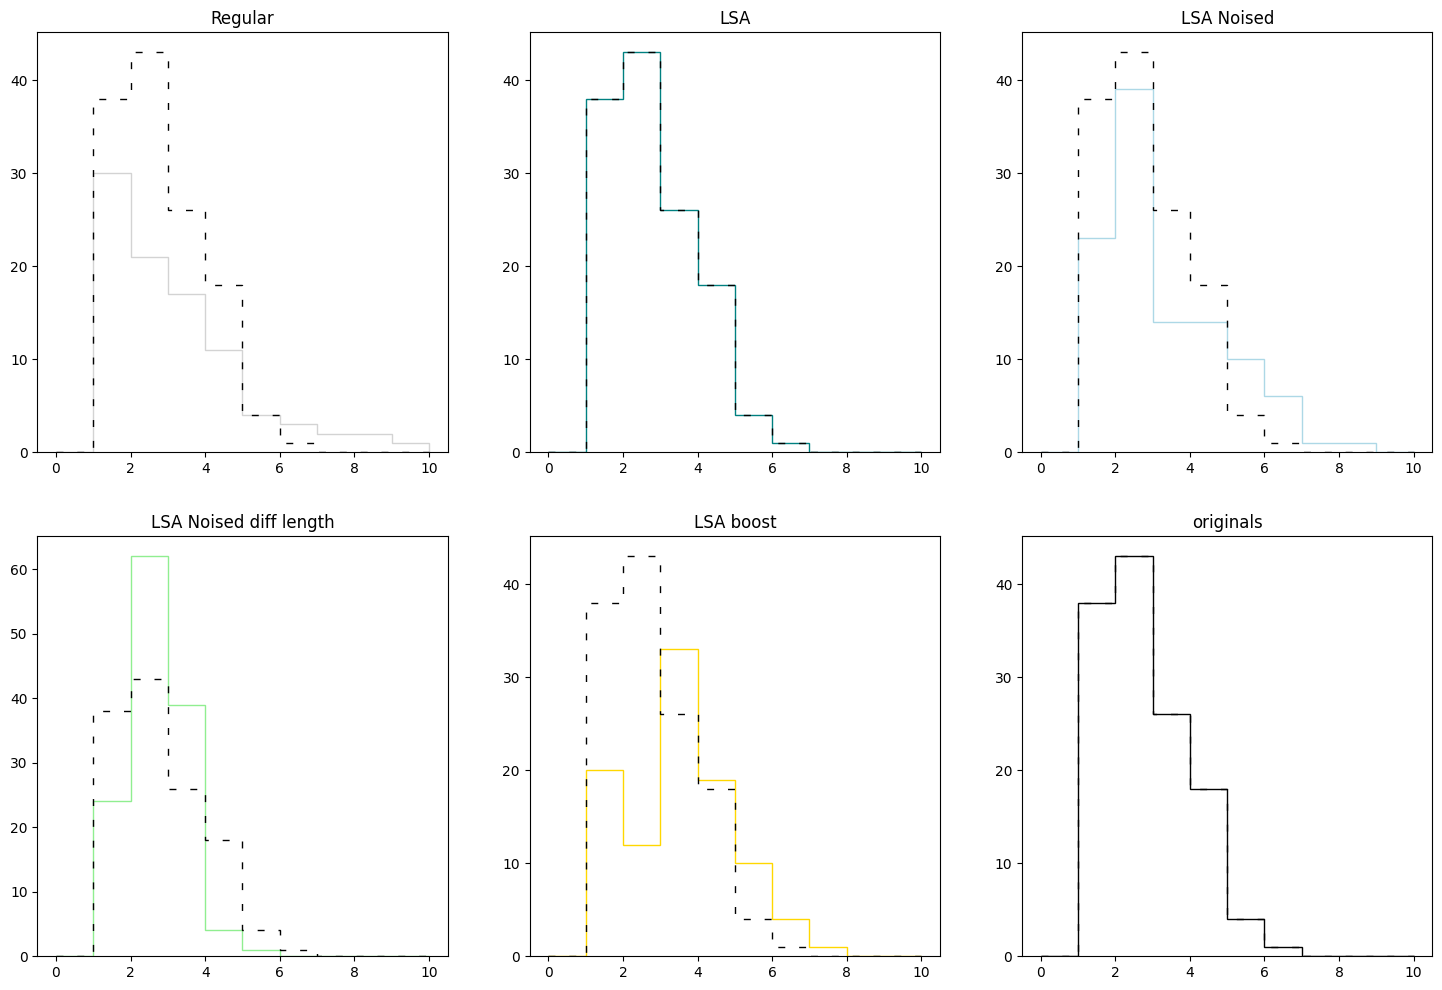

In [13]:
fig, axs = plt.subplots(2, 3, figsize=(18, 12))  # 2 rows, 3 columns

datasets = [
    ('Regular', avatar_visit_tib['patient_id_regular'].value_counts()),
    ('LSA', avatar_visit_tib['patient_id_lsa'].value_counts()),
    ('LSA Noised', avatar_visit_tib['patient_id_lsa_noised'].value_counts()),
    ('LSA Noised diff length', avatar_visit_tib['patient_id_lsa_noised_diff_length'].value_counts()),
    ('LSA boost', avatar_visit_tib['patient_id_lsa_boost'].value_counts()),
    ('originals', visit['patient_id'].value_counts())
]

for i, (label, data) in enumerate(datasets):
    ax = axs[i // 3, i % 3]
    ax.hist(np.array(data), bins=list(range(11)), histtype="step", label=label, color=map_color[label])
    ax.hist(np.array(datasets[5][1]), bins=list(range(11)), histtype="step", label=label, color=map_color["originals"], linestyle=(0, (5, 10)))
    ax.title.set_text(label)

# Move the legend outside the graph

plt.show()

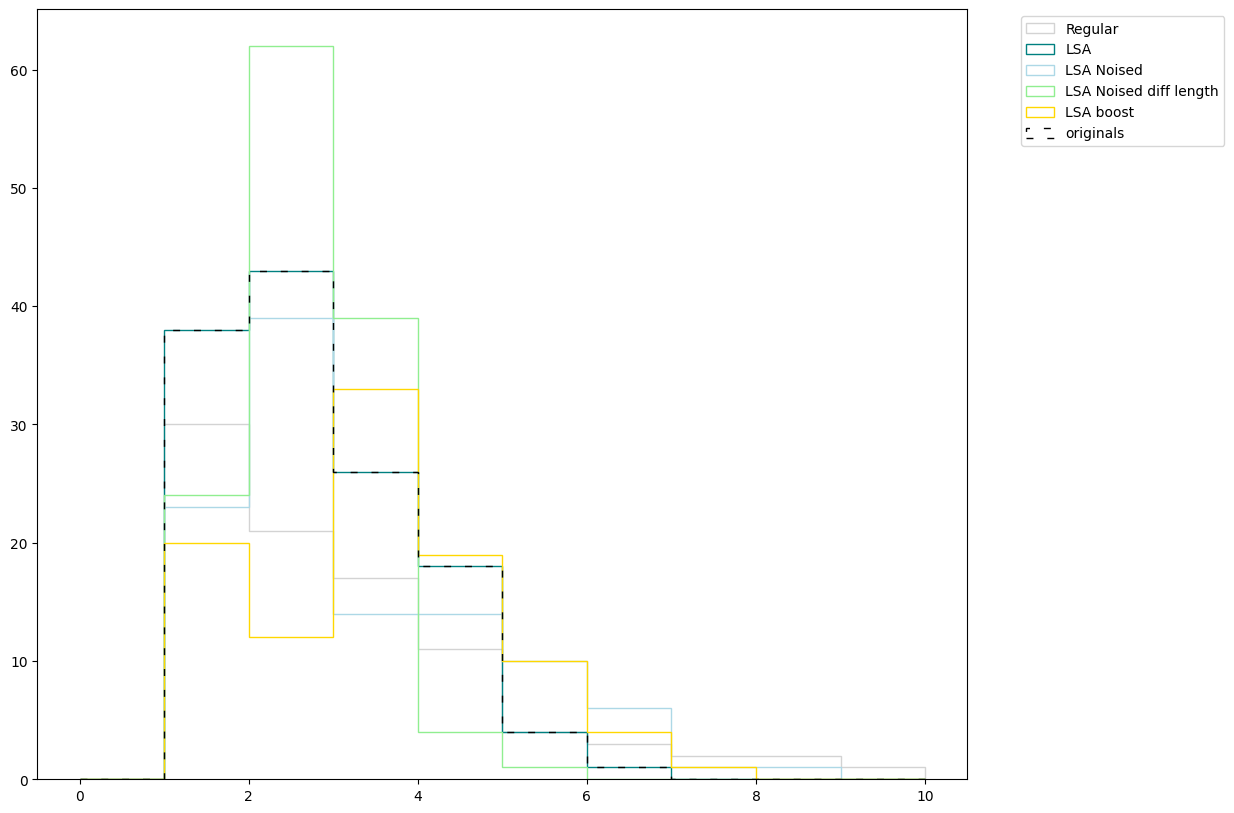

In [14]:
fig, ax = plt.subplots(figsize=(12, 10)) 

plt.hist(np.array(avatar_visit_tib['patient_id_regular'].value_counts()), bins=list(range(11)), histtype="step", color=map_color['Regular'], label="Regular")
plt.hist(np.array(avatar_visit_tib['patient_id_lsa'].value_counts()), bins=list(range(11)), histtype="step", color=map_color['LSA'], label="LSA")
plt.hist(np.array(avatar_visit_tib['patient_id_lsa_noised'].value_counts()), bins=list(range(11)), histtype="step", color=map_color['LSA Noised'], label="LSA Noised")
plt.hist(np.array(avatar_visit_tib['patient_id_lsa_noised_diff_length'].value_counts()), bins=list(range(11)), histtype="step", color=map_color['LSA Noised diff length'], label="LSA Noised diff length")
plt.hist(np.array(avatar_visit_tib['patient_id_lsa_boost'].value_counts()), bins=list(range(11)), histtype="step", color=map_color['LSA boost'], label="LSA boost")
plt.hist(np.array(visit['patient_id'].value_counts()), bins=list(range(11)), histtype="step", label="originals", color=map_color['originals'], linestyle=(0, (5, 10)))

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


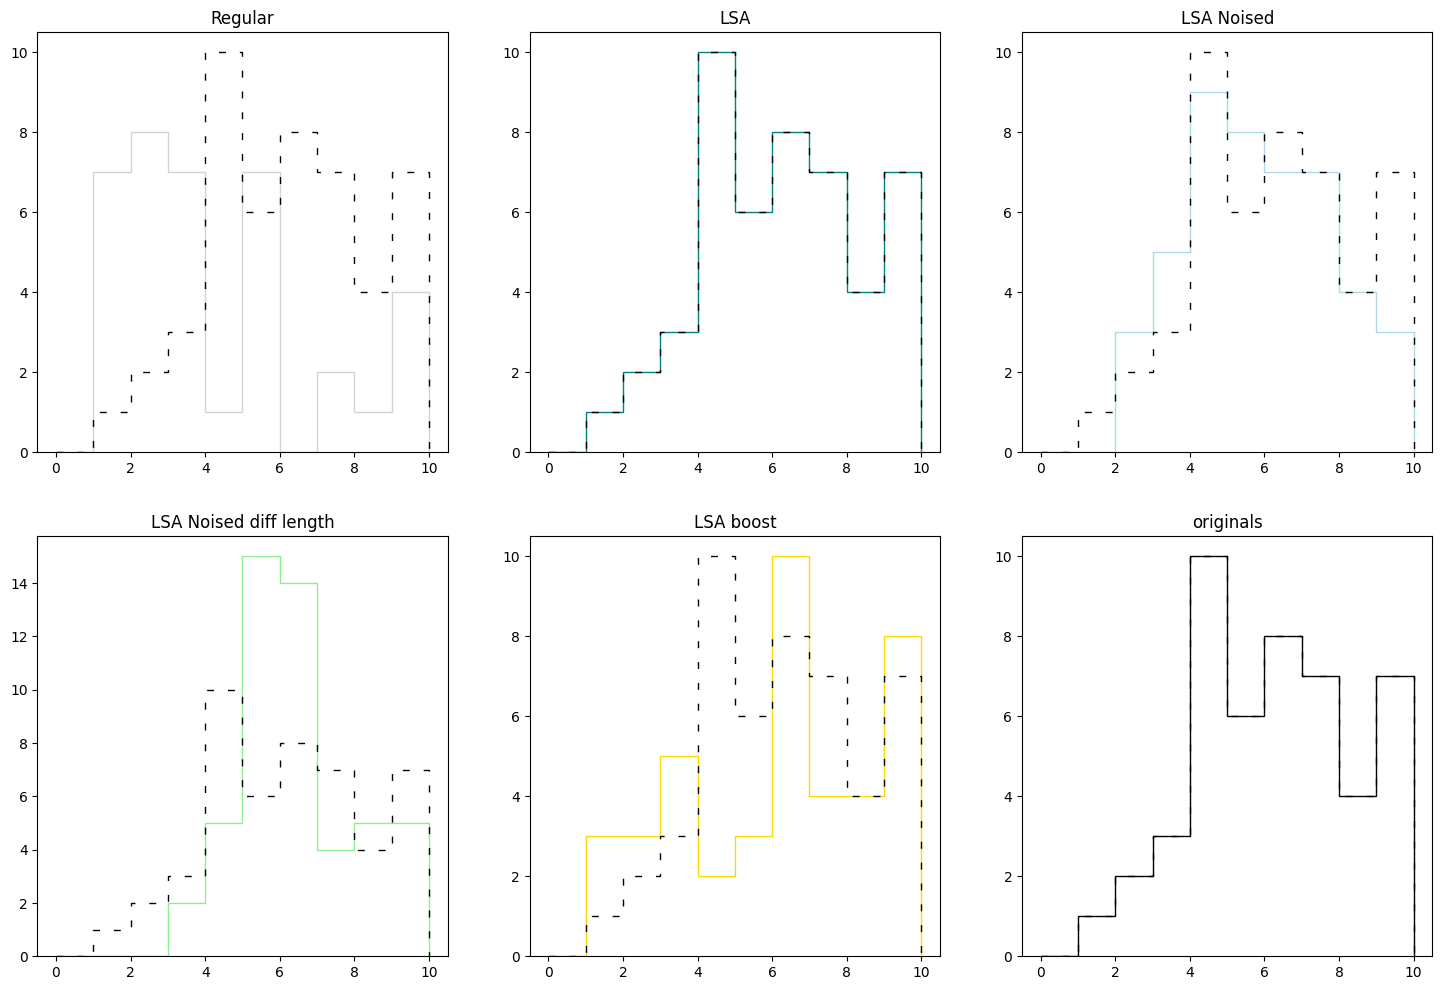

In [15]:
fig, axs = plt.subplots(2, 3, figsize=(18, 12))  # 2 rows, 3 columns

datasets = [
    ('Regular', avatar_visit_tib['doctor_id_regular'].value_counts()),
    ('LSA', avatar_visit_tib['doctor_id_lsa'].value_counts()),
    ('LSA Noised', avatar_visit_tib['doctor_id_lsa_noised'].value_counts()),
    ('LSA Noised diff length', avatar_visit_tib['doctor_id_lsa_noised_diff_length'].value_counts()),
    ('LSA boost', avatar_visit_tib['doctor_id_lsa_boost'].value_counts()),
    ('originals', visit['doctor_id'].value_counts())
]

for i, (label, data) in enumerate(datasets):
    ax = axs[i // 3, i % 3]
    ax.hist(np.array(data), bins=list(range(11)), histtype="step", label=label, color=map_color[label])
    ax.hist(np.array(datasets[5][1]), bins=list(range(11)), histtype="step", label=label, color=map_color["originals"], linestyle=(0, (5, 10)))
    ax.title.set_text(label)

# Move the legend outside the graph

plt.show()

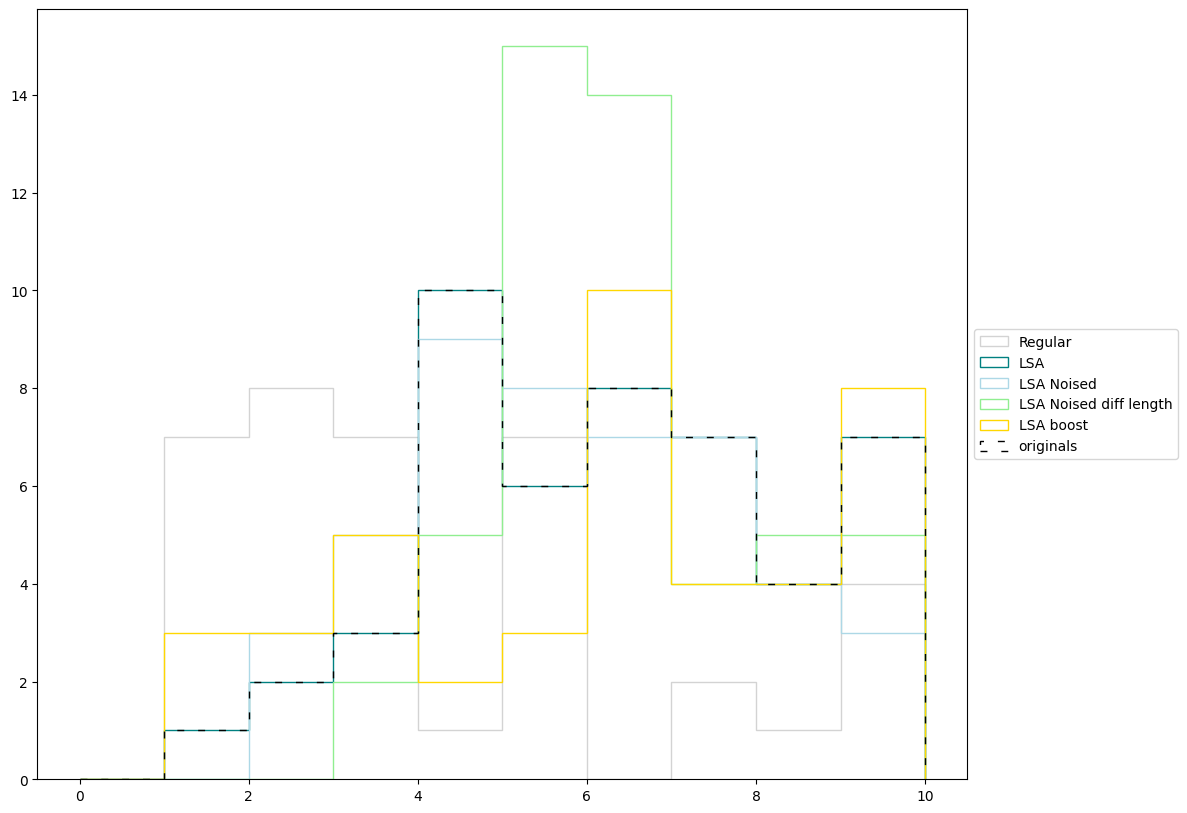

In [16]:
fig, ax = plt.subplots(figsize=(12, 10))

plt.hist(np.array(avatar_visit_tib['doctor_id_regular'].value_counts()), bins=list(range(11)), histtype="step", color=map_color['Regular'], label="Regular")
plt.hist(np.array(avatar_visit_tib['doctor_id_lsa'].value_counts()), bins=list(range(11)), histtype="step", color=map_color['LSA'], label="LSA")
plt.hist(np.array(avatar_visit_tib['doctor_id_lsa_noised'].value_counts()), bins=list(range(11)), histtype="step", color=map_color['LSA Noised'], label="LSA Noised")
plt.hist(np.array(avatar_visit_tib['doctor_id_lsa_noised_diff_length'].value_counts()), bins=list(range(11)), histtype="step", color=map_color['LSA Noised diff length'], label="LSA Noised diff length")
plt.hist(np.array(avatar_visit_tib['doctor_id_lsa_boost'].value_counts()), bins=list(range(11)), histtype="step", color=map_color['LSA boost'], label="LSA boost")
plt.hist(np.array(visit['doctor_id'].value_counts()), bins=list(range(11)), histtype="step", label="originals", color=map_color['originals'], linestyle=(0, (5, 10)))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


In [17]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

def visit_avat_flatten(iict):
    visit_avat_flat = avatar_visit_tib.drop(columns=["gender", "height", "age", "weight", "job", "age_doctor","exam","day_visit","temperature"]).join(
        avatar_patient_tib.set_index("patient_id"), on=f"patient_id_{iict}"
        )
    visit_avat_flat = visit_avat_flat.join(
            avatar_doctor_tib.drop(columns=["exam","day_visit","temperature"]).set_index("doctor_id"), on=f"doctor_id_{iict}"
        )
    visit_avat_flat['day_visit'] = pd.Categorical(visit_avat_flat['day_visit'], categories=day_order, ordered=True)
    visit_avat_flat=visit_avat_flat.sort_values('day_visit')
    return visit_avat_flat


In [18]:
#ORIGINALS
visit_after_bib['day_visit'] = pd.Categorical(visit_after_bib['day_visit'], categories=day_order, ordered=True)
visit_after_bib=visit_after_bib.sort_values('day_visit')

#REGULAR
visit_avat_flat_regular = visit_avat_flatten('regular')

#LSA
visit_avat_flat_lsa = visit_avat_flatten('lsa')

#LSA BOOST
visit_avat_flat_lsa_boost = visit_avat_flatten('lsa_boost')

#LSA NOISED
visit_avat_flat_lsa_noised = visit_avat_flatten('lsa_noised')

#LSA NOISED DIFF LENGTH
visit_avat_flat_lsa_noised_diff_length = visit_avat_flatten('lsa_noised_diff_length')


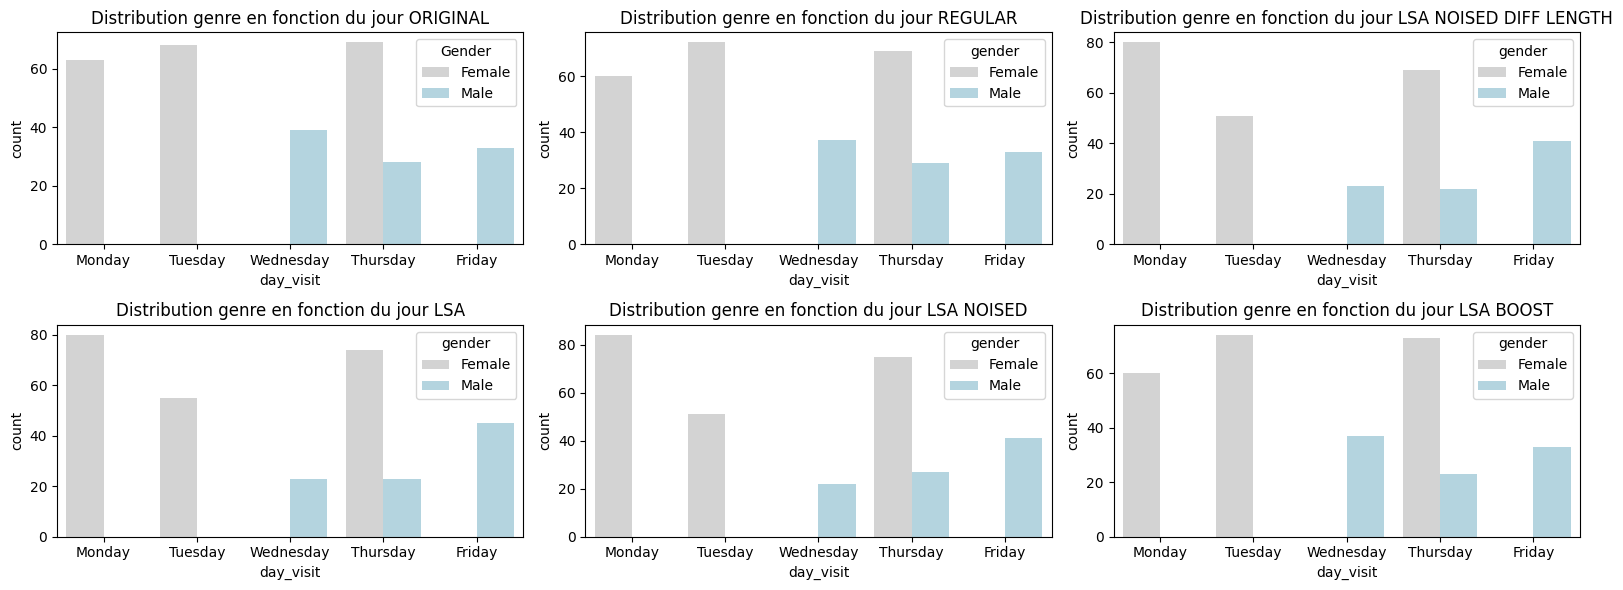

In [19]:
fig, axs = plt.subplots(2, 3, figsize=(16, 6))
palette = {"Male": "lightblue", "Female": "lightgrey"}
sns.countplot(data=visit_after_bib,x='day_visit',hue="gender", ax=axs[0,0],palette=palette)
axs[0,0].set_title("Distribution genre en fonction du jour ORIGINAL")
axs[0,0].legend(title='Gender') 
sns.countplot(data=visit_avat_flat_regular,x='day_visit',hue="gender", ax=axs[0,1],palette=palette)
axs[0,1].set_title("Distribution genre en fonction du jour REGULAR")
sns.countplot(data=visit_avat_flat_lsa,x='day_visit',hue="gender", ax=axs[1,0],palette=palette)
axs[1,0].set_title("Distribution genre en fonction du jour LSA") 
sns.countplot(data=visit_avat_flat_lsa_noised,x='day_visit',hue="gender", ax=axs[1,1],palette=palette)
axs[1,1].set_title("Distribution genre en fonction du jour LSA NOISED")
sns.countplot(data=visit_avat_flat_lsa_noised_diff_length,x='day_visit',hue='gender', ax=axs[0,2],palette=palette)
axs[0,2].set_title("Distribution genre en fonction du jour LSA NOISED DIFF LENGTH")
sns.countplot(data=visit_avat_flat_lsa_boost,x='day_visit',hue='gender', ax=axs[1,2],palette=palette)
axs[1,2].set_title("Distribution genre en fonction du jour LSA BOOST")
plt.tight_layout()
plt.show()

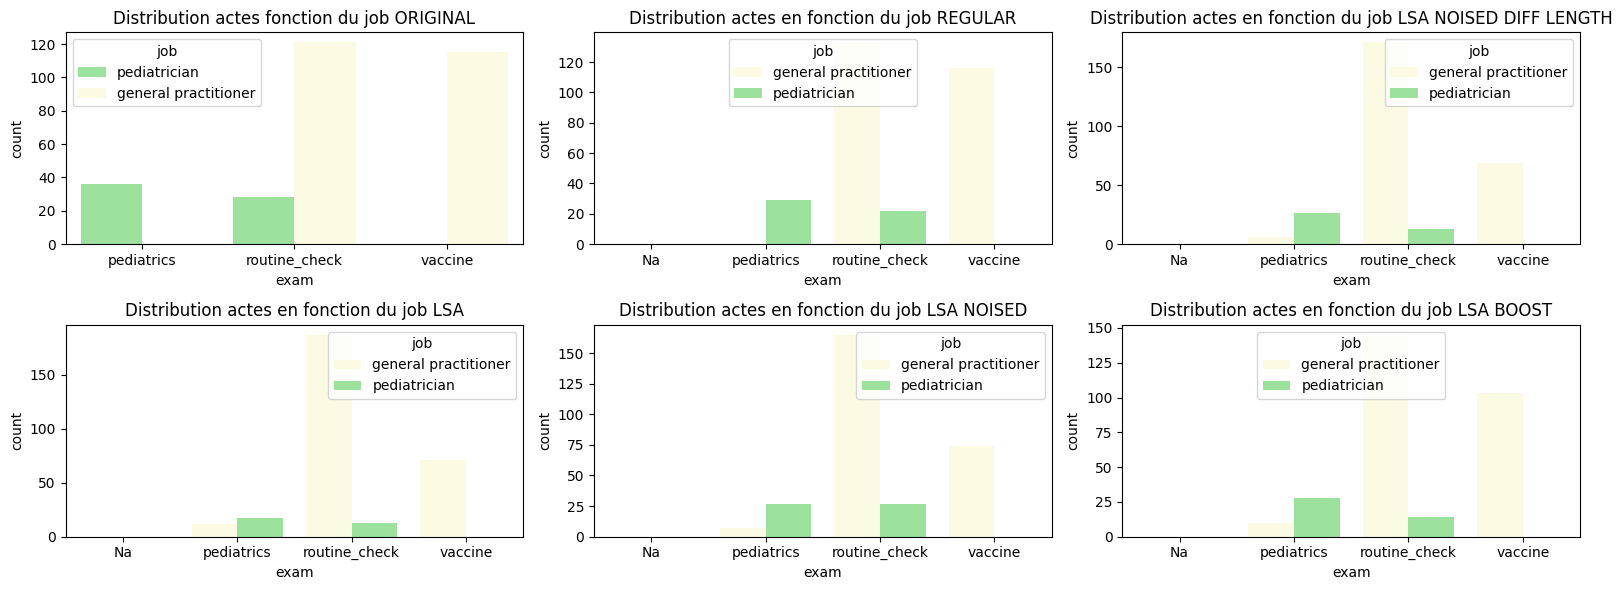

In [20]:
fig, axs = plt.subplots(2, 3, figsize=(16, 6))
palette = {"pediatrician": "lightgreen", "general practitioner": "lightyellow"}
sns.countplot(data=visit_after_bib.sort_values('exam'),x='exam',hue="job",ax=axs[0,0],palette=palette)
axs[0,0].set_title("Distribution actes fonction du job ORIGINAL")
axs[0,0].legend(title='job') 
sns.countplot(data=visit_avat_flat_regular.sort_values('exam'),x='exam',hue="job", ax=axs[0,1],palette=palette)
axs[0,1].set_title("Distribution actes en fonction du job REGULAR")
sns.countplot(data=visit_avat_flat_lsa.sort_values('exam'),x='exam',hue="job", ax=axs[1,0],palette=palette)
axs[1,0].set_title("Distribution actes en fonction du job LSA")
sns.countplot(data=visit_avat_flat_lsa_noised.sort_values('exam'),x='exam',hue="job", ax=axs[1,1],palette=palette)
axs[1,1].set_title("Distribution actes en fonction du job LSA NOISED")
sns.countplot(data=visit_avat_flat_lsa_noised_diff_length.sort_values('exam'),x='exam',hue="job", ax=axs[0,2],palette=palette)
axs[0,2].set_title("Distribution actes en fonction du job LSA NOISED DIFF LENGTH")
sns.countplot(data=visit_avat_flat_lsa_boost.sort_values('exam'),x='exam',hue="job", ax=axs[1,2],palette=palette)
axs[1,2].set_title("Distribution actes en fonction du job LSA BOOST")
plt.tight_layout()
plt.show()

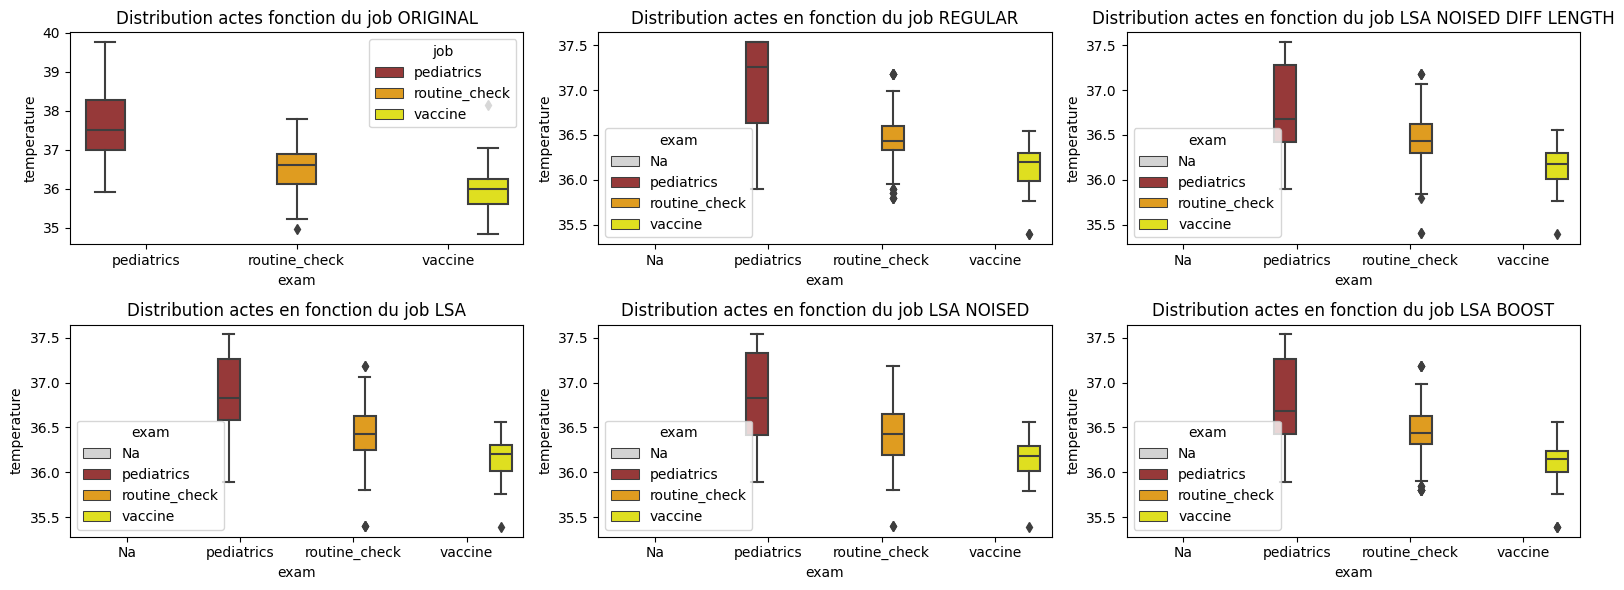

In [21]:
fig, axs = plt.subplots(2, 3,figsize=(16, 6))
palette = {"routine_check": "orange", "vaccine": "yellow","pediatrics":"brown","Na":"lightgrey"}
sns.boxplot(data=visit_temperature_after_bib.sort_values('exam'),x='exam',y='temperature',hue="exam",ax=axs[0,0],palette=palette)
axs[0,0].set_title("Distribution actes fonction du job ORIGINAL")
axs[0,0].legend(title='job') 
sns.boxplot(data=visit_avat_flat_regular.sort_values('exam'),x='exam',y='temperature',hue="exam", ax=axs[0,1],palette=palette)
axs[0,1].set_title("Distribution actes en fonction du job REGULAR")
sns.boxplot(data=visit_avat_flat_lsa.sort_values('exam'),x='exam',y='temperature',hue="exam", ax=axs[1,0],palette=palette)
axs[1,0].set_title("Distribution actes en fonction du job LSA")
sns.boxplot(data=visit_avat_flat_lsa_noised.sort_values('exam'),x='exam',y='temperature',hue="exam", ax=axs[1,1],palette=palette)
axs[1,1].set_title("Distribution actes en fonction du job LSA NOISED")
sns.boxplot(data=visit_avat_flat_lsa_noised_diff_length.sort_values('exam'),x='exam',y='temperature',hue="exam", ax=axs[0,2],palette=palette)
axs[0,2].set_title("Distribution actes en fonction du job LSA NOISED DIFF LENGTH")
sns.boxplot(data=visit_avat_flat_lsa_boost.sort_values('exam'),x='exam',y='temperature',hue="exam", ax=axs[1,2],palette=palette)
axs[1,2].set_title("Distribution actes en fonction du job LSA BOOST")
plt.tight_layout()
plt.show()

## Privacy

### Calcul

In [22]:
col=['regular','lsa','lsa_boost','lsa_noised','lsa_noised_diff_length']
row=['patient','doctor']

for c in col :
    avatar_visit_tib[f"same_patient_{c}"] = avatar_visit_tib[f"patient_id_{c}"] == visit["patient_id"]
    avatar_visit_tib[f"same_doctor_{c}"] = avatar_visit_tib[f"doctor_id_{c}"] == visit["doctor_id"]
    for c1 in col:
        if c1!=c:
            avatar_visit_tib[f"same_patient_{c}_{c1}"] = avatar_visit_tib[f"patient_id_{c}"] == avatar_visit_tib[f"patient_id_{c1}"]
            avatar_visit_tib[f"same_doctor_{c}_{c1}"] = avatar_visit_tib[f"doctor_id_{c}"] == avatar_visit_tib[f"doctor_id_{c1}"]
    avatar_visit_tib[f'same_patient_doctor_{c}']= (avatar_visit_tib[F"patient_id_{c}"] == visit["patient_id"]) & (avatar_visit_tib[f"doctor_id_{c}"] == visit["doctor_id"])

table=pd.DataFrame(index=['REGULAR','LSA','LSA BOOST','LSA NOISED','LSA NOISED DIFF LENGTH'])

for c,i in zip(col,table.index):
    table.loc[i,'nb_visites']=avatar_visit_tib[f'patient_id_{c}'].count()
    table.loc[i,'nb_patient']=avatar_visit_tib[f'patient_id_{c}'].nunique()
    table.loc[i,'nb_doctor']=avatar_visit_tib[f'doctor_id_{c}'].nunique()
    table.loc[i,'nb_patient_doctor']=avatar_visit_tib[f'same_patient_doctor_{c}'].sum()
    table.loc[i,'nb_patient_same_original']=avatar_visit_tib[f'same_patient_{c}'].sum()
    table.loc[i,'nb_doctor_same_original']=avatar_visit_tib[f'same_doctor_{c}'].sum()
    for c1 in col:
        if c1!=c:
            table.loc[i,f'nb_patient_same_{c1}']=avatar_visit_tib[f'same_patient_{c}_{c1}'].sum()
            table.loc[i,f'nb_doctor_same_{c1}']=avatar_visit_tib[f'same_doctor_{c}_{c1}'].sum()
table_patient=table[['nb_visites','nb_patient','nb_patient_same_original','nb_patient_same_regular','nb_patient_same_lsa','nb_patient_same_lsa_boost','nb_patient_same_lsa_noised','nb_patient_same_lsa_noised_diff_length','nb_patient_doctor']]
table_doctor=table[['nb_visites','nb_doctor','nb_doctor_same_original','nb_doctor_same_regular','nb_doctor_same_lsa','nb_doctor_same_lsa_boost','nb_doctor_same_lsa_noised','nb_doctor_same_lsa_noised_diff_length','nb_patient_doctor']]

In [23]:
# TABLE LINKS
doctor_ref = TableReference(
    dataset_id=dataset_doctor.id,
    is_individual_level=True,
)
patient_ref = TableReference(
    dataset_id=dataset_patient.id,
    is_individual_level=True,
)
visit_ref = TableReference(
    dataset_id=dataset_visit_tib.id,
    is_individual_level=False,
)


table_links = [
    TableLink(
        parent_table=patient_ref,
        child_table=visit_ref,
        link_method="bottom_projection",
        parent_link_key="patient_id",
        child_link_key="patient_id",
    ),
    TableLink(
        parent_table=doctor_ref,
        child_table=visit_ref,
        link_method="bottom_projection",
        parent_link_key="doctor_id",
        child_link_key="doctor_id",
    ),
]

In [24]:
## AVATAR PATIENT
avatar_patient_tib=avatar_patient_tib[['patient_id','gender','height','age','weight']]
dataset_avatar_patient_tib = client.pandas_integration.upload_dataframe(avatar_patient_tib,
                                                                        name="patient_avat",
                                                                   identifier_variables=["patient_id"])

## AVATAR DOCTOR 
avatar_doctor_tib=avatar_doctor_tib[['doctor_id','job','age_doctor']]
dataset_avatar_doctor_tib = client.pandas_integration.upload_dataframe(avatar_doctor_tib,
                                                                        name="doctor_avat",
                                                                        identifier_variables=["doctor_id"])

## AVATAR VISIT 

# REGULAR
avatar_visit_regular_tib=avatar_visit_tib[['visit_id','patient_id_regular','doctor_id_regular','day_visit','exam','temperature']]
avatar_visit_regular_tib.columns=['visit_id','patient_id','doctor_id','day_visit','exam','temperature']
dataset_avatar_visit_regular_tib = client.pandas_integration.upload_dataframe(avatar_visit_regular_tib,
                                                                        name="visit_avat",
                                                                        identifier_variables=["visit_id","patient_id","doctor_id"])

#LSA
avatar_visit_lsa_tib=avatar_visit_tib[['visit_id','patient_id_lsa','doctor_id_lsa','day_visit','exam','temperature']]
avatar_visit_lsa_tib.columns=['visit_id','patient_id','doctor_id','day_visit','exam','temperature']
dataset_avatar_visit_lsa_tib = client.pandas_integration.upload_dataframe(avatar_visit_lsa_tib,
                                                                        name="visit_avat",
                                                                        identifier_variables=["visit_id","patient_id","doctor_id"])

#LSA BOOST
avatar_visit_lsa_boost_tib=avatar_visit_tib[['visit_id','patient_id_lsa_boost','doctor_id_lsa_boost','day_visit','exam','temperature']]
avatar_visit_lsa_boost_tib.columns=['visit_id','patient_id','doctor_id','day_visit','exam','temperature']
dataset_avatar_visit_lsa_boost_tib = client.pandas_integration.upload_dataframe(avatar_visit_lsa_boost_tib,
                                                                        name="visit_avat",
                                                                        identifier_variables=["visit_id","patient_id","doctor_id"])

#LSA NOISED
avatar_visit_lsa_noised_tib=avatar_visit_tib[['visit_id','patient_id_lsa_noised','doctor_id_lsa_noised','day_visit','exam','temperature']]
avatar_visit_lsa_noised_tib.columns=['visit_id','patient_id','doctor_id','day_visit','exam','temperature']
dataset_avatar_visit_lsa_noised_tib = client.pandas_integration.upload_dataframe(avatar_visit_lsa_noised_tib,
                                                                        name="visit_avat",
                                                                        identifier_variables=["visit_id","patient_id","doctor_id"])


#LSA NOISED
avatar_visit_lsa_noised_diff_length_tib=avatar_visit_tib[['visit_id','patient_id_lsa_noised_diff_length','doctor_id_lsa_noised_diff_length','day_visit','exam','temperature']]
avatar_visit_lsa_noised_diff_length_tib.columns=['visit_id','patient_id','doctor_id','day_visit','exam','temperature']
dataset_avatar_visit_lsa_noised_diff_length_tib = client.pandas_integration.upload_dataframe(avatar_visit_lsa_noised_diff_length_tib,
                                                                        name="visit_avat",
                                                                        identifier_variables=["visit_id","patient_id","doctor_id"])



In [25]:
def calculate_privacy_metric_tib(dataset_avatar_visit):
    privacy_parameters = parameters = [
        PrivacyMetricsParameters(
            original_id=dataset_patient.id,
            unshuffled_avatars_id=dataset_avatar_patient_tib.id,
        ),
        PrivacyMetricsParameters(
            original_id=dataset_doctor.id,
            unshuffled_avatars_id=dataset_avatar_doctor_tib.id,
        ),
        PrivacyMetricsParameters(
            original_id=dataset_visit_tib.id,
            unshuffled_avatars_id=dataset_avatar_visit.id,
        ),
    ]

    privacy_job = client.jobs.create_privacy_metrics_multi_table_job(
        PrivacyMetricsMultiTableJobCreate(
            parameters=PrivacyMetricsMultiTableParameters(
                table_links=table_links,
                table_parameters=privacy_parameters,
            )
        )
    )

    privacy_job = client.jobs.get_privacy_metrics_multi_table_job(privacy_job.id, timeout=1000)
    return privacy_job

privacy_job_regular_tib=calculate_privacy_metric_tib(dataset_avatar_visit_regular_tib)
privacy_job_lsa_tib=calculate_privacy_metric_tib(dataset_avatar_visit_lsa_tib)
privacy_job_lsa_boost_tib=calculate_privacy_metric_tib(dataset_avatar_visit_lsa_boost_tib)
privacy_job_lsa_noised_tib=calculate_privacy_metric_tib(dataset_avatar_visit_lsa_noised_tib)
#privacy_job_lsa_noised_diff_length_tib=calculate_privacy_metric_tib(dataset_avatar_visit_lsa_noised_diff_length_tib)




In [26]:
def to_df_metrics(privacy_job):
    index = ['standalone_doctor.doctor_id', 'standalone_patient.patient_id', 
                      'to_bottom_id_propagated_doctor_id', 'to_bottom_id_propagated_patient_id',
                      'to_top_enriched_doctor.doctor_id', 'to_top_enriched_patient.patient_id',
                      'full_enriched_doctor.doctor_id','full_enriched_patient.patient_id']
    data=privacy_job.result.details
    data_dict = {
        'Hidden Rate': [d.hidden_rate for d in data],
        'Local Cloaking': [d.local_cloaking for d in data],
        'Distance to Closest': [d.distance_to_closest for d in data],
        'Closest Distances Ratio': [d.closest_distances_ratio for d in data],
        'Column Direct Match Protection': [d.column_direct_match_protection for d in data],
        'Categorical Hidden Rate': [d.categorical_hidden_rate for d in data],
        'Row Direct Match Protection': [d.row_direct_match_protection for d in data],
        'Table': [d.computation_type.name + "_" +str(d.individual_identifier_variable ) for d in data]

    }

    df_regular = pd.DataFrame(data_dict)
    df_regular.set_index('Table', inplace=True)
    df_regular = df_regular.reindex(index)
    return df_regular

In [27]:
#REGULAR
df_regular=to_df_metrics(privacy_job_regular_tib)


#LSA
df_lsa=to_df_metrics(privacy_job_lsa_tib)

#LSA BOOST
df_lsa_boost=to_df_metrics(privacy_job_lsa_boost_tib)

#LSA NOISED
df_lsa_noised=to_df_metrics(privacy_job_lsa_noised_tib)

#LSA NOISED DIFF LENGTH
#df_lsa_noised_diff_length=to_df_metrics(privacy_job_lsa_noised_diff_length_tib)

### affichage 

In [28]:
table_patient

,nb_visites,nb_patient,nb_patient_same_original,nb_patient_same_regular,nb_patient_same_lsa,nb_patient_same_lsa_boost,nb_patient_same_lsa_noised,nb_patient_same_lsa_noised_diff_length,nb_patient_doctor
REGULAR,300.0,95.0,22.0,NaN,136.0,229.0,126.0,128.0,2.0
LSA,300.0,130.0,15.0,136.0,NaN,151.0,147.0,173.0,1.0
LSA BOOST,300.0,99.0,18.0,229.0,151.0,NaN,136.0,144.0,2.0
LSA NOISED,300.0,108.0,9.0,126.0,147.0,136.0,NaN,163.0,0.0
LSA NOISED DIFF LENGTH,286.0,130.0,17.0,128.0,173.0,144.0,163.0,NaN,1.0


In [29]:
table_doctor

,nb_visites,nb_doctor,nb_doctor_same_original,nb_doctor_same_regular,nb_doctor_same_lsa,nb_doctor_same_lsa_boost,nb_doctor_same_lsa_noised,nb_doctor_same_lsa_noised_diff_length,nb_patient_doctor
REGULAR,300.0,44.0,15.0,NaN,123.0,169.0,131.0,138.0,2.0
LSA,300.0,50.0,19.0,123.0,NaN,181.0,153.0,203.0,1.0
LSA BOOST,300.0,47.0,17.0,169.0,181.0,NaN,155.0,190.0,2.0
LSA NOISED,300.0,50.0,15.0,131.0,153.0,155.0,NaN,200.0,0.0
LSA NOISED DIFF LENGTH,286.0,50.0,17.0,138.0,203.0,190.0,200.0,NaN,1.0


In [30]:
df_regular

,Hidden Rate,Local Cloaking,Distance to Closest,Closest Distances Ratio,Column Direct Match Protection,Categorical Hidden Rate,Row Direct Match Protection
Table,,,,,,,
standalone_doctor.doctor_id,94.00,20.5,0.018660,0.518100,0.0,100.00,100.0
standalone_patient.patient_id,97.33,26.0,0.252500,0.800200,0.0,100.00,100.0
to_bottom_id_propagated_doctor_id,94.00,12.0,0.018310,0.511700,0.0,100.00,100.0
to_bottom_id_propagated_patient_id,94.00,12.0,0.018310,0.511700,0.0,100.00,100.0
to_top_enriched_doctor.doctor_id,94.00,13.0,0.785600,0.622100,0.0,66.67,100.0
to_top_enriched_patient.patient_id,94.00,21.5,0.728600,0.782600,0.0,100.00,100.0
full_enriched_doctor.doctor_id,97.00,11.0,0.654489,0.771246,0.0,100.00,100.0
full_enriched_patient.patient_id,95.00,17.0,0.654489,0.771246,0.0,100.00,100.0


In [31]:
df_lsa

,Hidden Rate,Local Cloaking,Distance to Closest,Closest Distances Ratio,Column Direct Match Protection,Categorical Hidden Rate,Row Direct Match Protection
Table,,,,,,,
standalone_doctor.doctor_id,94.000000,20.5,0.018660,0.518100,0.0,100.00,100.0
standalone_patient.patient_id,97.330000,26.0,0.252500,0.800200,0.0,100.00,100.0
to_bottom_id_propagated_doctor_id,94.000000,12.0,0.018310,0.511700,0.0,100.00,100.0
to_bottom_id_propagated_patient_id,94.000000,12.0,0.018310,0.511700,0.0,100.00,100.0
to_top_enriched_doctor.doctor_id,72.000000,3.0,0.577600,0.759400,0.0,83.33,100.0
to_top_enriched_patient.patient_id,78.000000,2.0,0.455800,0.713000,0.0,75.00,100.0
full_enriched_doctor.doctor_id,96.333333,16.0,0.736799,0.793629,0.0,100.00,100.0
full_enriched_patient.patient_id,92.666667,19.5,0.736799,0.793629,0.0,100.00,100.0


In [32]:
df_lsa_boost

,Hidden Rate,Local Cloaking,Distance to Closest,Closest Distances Ratio,Column Direct Match Protection,Categorical Hidden Rate,Row Direct Match Protection
Table,,,,,,,
standalone_doctor.doctor_id,94.000000,20.5,0.018660,0.518100,0.0,100.00,100.0
standalone_patient.patient_id,97.330000,26.0,0.252500,0.800200,0.0,100.00,100.0
to_bottom_id_propagated_doctor_id,94.000000,12.0,0.018310,0.511700,0.0,100.00,100.0
to_bottom_id_propagated_patient_id,94.000000,12.0,0.018310,0.511700,0.0,100.00,100.0
to_top_enriched_doctor.doctor_id,90.000000,6.5,1.065000,0.806400,0.0,83.33,100.0
to_top_enriched_patient.patient_id,94.000000,17.5,0.699000,0.766600,0.0,100.00,100.0
full_enriched_doctor.doctor_id,96.333333,13.0,0.675795,0.776181,0.0,100.00,100.0
full_enriched_patient.patient_id,94.000000,19.0,0.675795,0.776181,0.0,100.00,100.0


In [33]:
df_lsa_noised

,Hidden Rate,Local Cloaking,Distance to Closest,Closest Distances Ratio,Column Direct Match Protection,Categorical Hidden Rate,Row Direct Match Protection
Table,,,,,,,
standalone_doctor.doctor_id,94.000000,20.5,0.018660,0.518100,0.0,100.00,100.0
standalone_patient.patient_id,97.330000,26.0,0.252500,0.800200,0.0,100.00,100.0
to_bottom_id_propagated_doctor_id,94.000000,12.0,0.018310,0.511700,0.0,100.00,100.0
to_bottom_id_propagated_patient_id,94.000000,12.0,0.018310,0.511700,0.0,100.00,100.0
to_top_enriched_doctor.doctor_id,96.000000,10.5,0.659900,0.619600,0.0,83.33,100.0
to_top_enriched_patient.patient_id,94.000000,15.5,0.601900,0.692700,0.0,100.00,100.0
full_enriched_doctor.doctor_id,96.000000,14.0,0.752519,0.812149,0.0,100.00,100.0
full_enriched_patient.patient_id,95.333333,22.5,0.752519,0.812149,0.0,100.00,100.0
